# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only
Agent can only bet a fixed amount quantity

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
best_params

{'OPEN_THRE': 0.8,
 'CLOS_THRE': 0.7,
 'period': 15,
 'verbose': 0,
 'prefix': 'Gridsearch',
 'kellycriterion': False,
 'fixed_amount': 0.1}

In [4]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
521369,1703818259999,0.000026,1m,2023-12-29 02:50:59.999,0.000028,-0.000002,-0.221338
521370,1703818319999,0.000026,1m,2023-12-29 02:51:59.999,0.000028,-0.000002,-0.093366
521371,1703818379999,0.000026,1m,2023-12-29 02:52:59.999,0.000028,-0.000002,0.082677
521372,1703818439999,0.000026,1m,2023-12-29 02:53:59.999,0.000028,-0.000002,0.381874
521373,1703818499999,0.000026,1m,2023-12-29 02:54:59.999,0.000028,-0.000002,0.577737
521374,1703818559999,0.000026,1m,2023-12-29 02:55:59.999,0.000028,-0.000002,1.842014
521375,1703818619999,0.000026,1m,2023-12-29 02:56:59.999,0.000028,-0.000002,1.903178
521376,1703818679999,0.000026,1m,2023-12-29 02:57:59.999,0.000028,-0.000002,1.802383
521377,1703818739999,0.000026,1m,2023-12-29 02:58:59.999,0.000028,-0.000002,2.952825
521378,1703818799999,0.000026,1m,2023-12-29 02:59:59.999,0.000028,-0.000002,4.854427


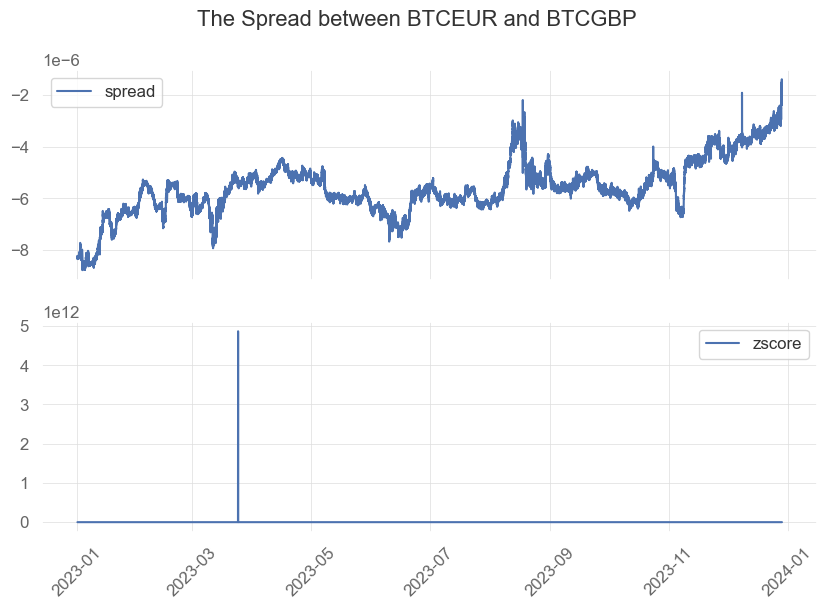

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [6]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [7]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## Train the Model with Trading Env

In [8]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/A2C_1
Deleted: logs/restrict_thres/DQN_1
Deleted: logs/restrict_thres/PPO_1


In [9]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [10]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [11]:
'''DQN'''

model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

Output()

## Create the Custom Test Env

In [12]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [13]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 38475


## Test Env with Trained Model

In [14]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 11/38475 [00:00<05:53, 108.89it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.76636244])}, action: 1, reward:1.0, networth: 1.0


 10%|█         | 3860/38475 [00:48<06:55, 83.40it/s] 

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([4.18083697])}, action: 0, reward:1.0, networth: 1.0206


 20%|██        | 7713/38475 [01:26<04:17, 119.35it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.48965029])}, action: 1, reward:1.0, networth: 1.0536


 30%|███       | 11555/38475 [02:02<03:40, 121.81it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.5302316])}, action: 2, reward:1.0, networth: 1.0722


 40%|████      | 15413/38475 [02:35<02:58, 129.52it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-0.80709601])}, action: 2, reward:1.0, networth: 1.1095


 50%|█████     | 19265/38475 [03:06<02:20, 136.82it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.79435192])}, action: 2, reward:1.0, networth: 1.167


 60%|██████    | 23103/38475 [03:36<02:07, 120.67it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.87636832])}, action: 0, reward:1.0, networth: 1.201


 70%|███████   | 26956/38475 [04:07<01:32, 124.34it/s]

signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.1278341])}, action: 0, reward:1.0, networth: 1.2608


 80%|████████  | 30793/38475 [04:40<01:06, 114.84it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([0.80698794])}, action: 0, reward:1.0, networth: 1.31


 90%|█████████ | 34641/38475 [05:13<00:32, 118.81it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.714942])}, action: 0, reward:1.0, networth: 1.354


100%|██████████| 38475/38475 [05:47<00:00, 110.65it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09010441])}, action: 1, reward:1.0, networth: 1.4094
Finished
networth: 1.40938365382791


In [15]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 14/38475 [00:00<04:51, 132.07it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.76636244])}, action: 0, reward:0.0, networth: 1.0


 10%|█         | 3861/38475 [00:40<06:07, 94.13it/s] 

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([4.18083697])}, action: 0, reward:1.0, networth: 1.0214


 20%|██        | 7720/38475 [01:18<04:16, 120.12it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.48965029])}, action: 1, reward:1.0, networth: 1.0557


 30%|███       | 11560/38475 [01:52<03:32, 126.69it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.5302316])}, action: 2, reward:1.0, networth: 1.0729


 40%|████      | 15405/38475 [02:24<03:32, 108.69it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-0.80709601])}, action: 2, reward:1.0, networth: 1.1114


 50%|█████     | 19253/38475 [02:58<02:55, 109.43it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.79435192])}, action: 2, reward:1.0, networth: 1.1706


 60%|██████    | 23095/38475 [03:34<02:26, 104.68it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.87636832])}, action: 0, reward:1.0, networth: 1.2052


 70%|███████   | 26950/38475 [04:12<01:53, 101.86it/s]

signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.1278341])}, action: 0, reward:1.0, networth: 1.2666


 80%|████████  | 30793/38475 [04:53<01:12, 105.67it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([0.80698794])}, action: 0, reward:1.0, networth: 1.3177


 90%|█████████ | 34637/38475 [05:33<00:44, 85.38it/s] 

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.714942])}, action: 0, reward:1.0, networth: 1.3643


100%|██████████| 38475/38475 [06:15<00:00, 102.37it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.09010441])}, action: 1, reward:1.006, networth: 1.4208
Finished
networth: 1.420821702332696


In [16]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

obs, _ = test_env_dqn.reset()

for i in trange(max_test_len):
    action, _states = model_dqn.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
    if i%int(max_test_len/10)==0:
        test_env_dqn.render()

test_env_dqn.close()

  0%|          | 11/38475 [00:00<06:10, 103.74it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.76636244])}, action: 1, reward:1.0, networth: 1.0


 10%|█         | 3861/38475 [00:38<06:17, 91.63it/s] 

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([4.18083697])}, action: 0, reward:1.0, networth: 1.0193


 20%|██        | 7705/38475 [01:14<04:15, 120.51it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.48965029])}, action: 1, reward:1.0, networth: 1.0495


 30%|███       | 11555/38475 [01:48<03:37, 123.53it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-1.5302316])}, action: 2, reward:1.0, networth: 1.0598


 40%|████      | 15413/38475 [02:24<03:18, 115.90it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-0.80709601])}, action: 2, reward:1.0, networth: 1.0942


 50%|█████     | 19254/38475 [02:59<02:45, 116.45it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.79435192])}, action: 2, reward:1.0, networth: 1.1502


 60%|██████    | 23108/38475 [03:32<02:00, 127.89it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.87636832])}, action: 0, reward:1.0, networth: 1.1827


 70%|███████   | 26945/38475 [04:05<01:30, 127.19it/s]

signal: {'position': array(1, dtype=int64), 'zone': 0, 'zscore': array([1.1278341])}, action: 0, reward:1.0, networth: 1.2384


 80%|████████  | 30796/38475 [04:37<01:01, 125.49it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([0.80698794])}, action: 0, reward:1.0, networth: 1.2843


 90%|█████████ | 34641/38475 [05:12<00:32, 117.00it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.714942])}, action: 0, reward:1.0, networth: 1.3258


100%|██████████| 38475/38475 [05:48<00:00, 110.30it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.09010441])}, action: 1, reward:1.0, networth: 1.3775
Finished
networth: 1.3775235691778833


## Also run randomly generated actions

In [17]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 16/38475 [00:00<04:15, 150.68it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([0.76636244])}, action: 2, reward:0.0, networth: 1.0


 10%|█         | 3870/38475 [00:32<04:30, 128.01it/s]

signal: {'position': 1, 'zone': 0, 'zscore': array([4.18083697])}, action: 2, reward:0.0, networth: 0.9957


 20%|██        | 7722/38475 [01:01<03:54, 131.14it/s]

signal: {'position': 1, 'zone': 2, 'zscore': array([0.48965029])}, action: 1, reward:1.0, networth: 0.9968


 30%|███       | 11567/38475 [01:29<03:06, 144.02it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-1.5302316])}, action: 2, reward:1.0, networth: 0.9867


 40%|████      | 15416/38475 [01:55<02:39, 144.18it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-0.80709601])}, action: 0, reward:0.0, networth: 0.9893


 50%|█████     | 19251/38475 [02:22<02:09, 148.43it/s]

signal: {'position': 1, 'zone': 3, 'zscore': array([-0.79435192])}, action: 1, reward:1.0, networth: 0.9916


 60%|██████    | 23101/38475 [02:49<01:49, 140.52it/s]

signal: {'position': 1, 'zone': 0, 'zscore': array([1.87636832])}, action: 0, reward:1.0, networth: 0.9886


 70%|███████   | 26956/38475 [03:16<01:17, 148.73it/s]

signal: {'position': 0, 'zone': 0, 'zscore': array([1.1278341])}, action: 2, reward:0.0, networth: 0.9812


 80%|████████  | 30794/38475 [03:46<00:52, 147.28it/s]

signal: {'position': 2, 'zone': 0, 'zscore': array([0.80698794])}, action: 0, reward:1.0, networth: 0.9841


 90%|█████████ | 34652/38475 [04:15<00:28, 133.65it/s]

signal: {'position': 2, 'zone': 0, 'zscore': array([1.714942])}, action: 1, reward:-0.0, networth: 0.9857


100%|██████████| 38475/38475 [04:44<00:00, 135.44it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([0.09010441])}, action: 1, reward:1.009, networth: 0.9906
Finished
networth: 0.9905878448912417


### Analyze with Quanstats

In [18]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-12-27 18:05:59.999000', '1.420821702332696']
The ending capital of networth_dqn.csv is ['2023-12-27 18:05:59.999000', '1.3775235691778833']
The ending capital of networth_ppo.csv is ['2023-12-27 18:05:59.999000', '1.40938365382791']
The best model is networth_a2c.csv


In [19]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 13796%
Total orders count: 38474
Total long action: 11328
Total short action: 12580
Won orders count: 5368
Lost orders count: 788
Win/Loss order ratio: 6.812182741116751
Max win: 0.002724957765728231
Max Loss: -0.0033006027609765454
Avg order pnl: 1.0937820406838278e-05
Avg order pnl won: 9.030229489838114e-05
Avg order pnl lost: -8.111804147438331e-05


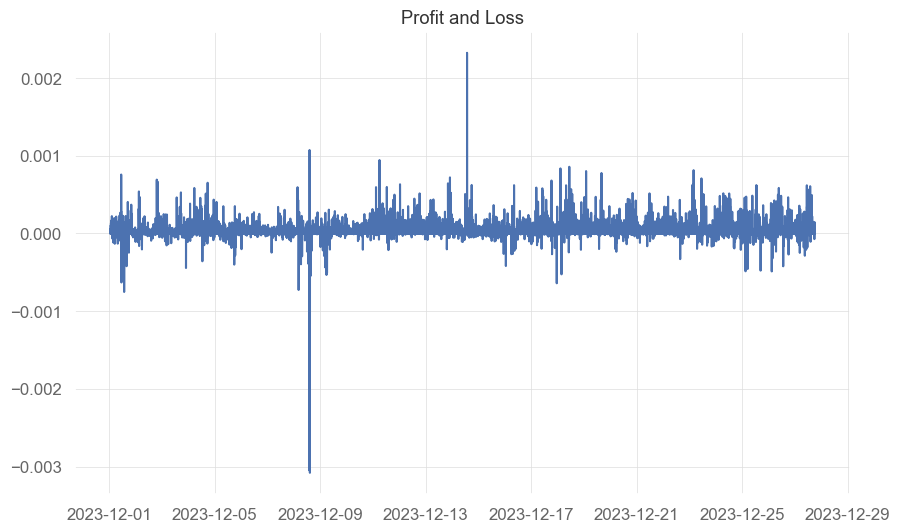

In [20]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-12-01
End Period                 2023-12-27
Risk-Free Rate             0.0%
Time in Market             17.0%

Cumulative Return          42.08%
CAGR﹪                     2909.27%

Sharpe                     2.72
Prob. Sharpe Ratio         100.0%
Smart Sharpe               2.64
Sortino                    5.26
Smart Sortino              5.11
Sortino/√2                 3.72
Smart Sortino/√2           3.61
Omega                      7.41

Max Drawdown               -0.64%
Longest DD Days            2
Volatility (ann.)          0.08%
Calmar                     4522.64
Skew                       -4.12
Kurtosis                   716.83

Expected Daily %           0.0%
Expected Monthly %         42.08%
Expected Yearly %          42.08%
Kelly Criterion            75.42%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive Wins 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-12-08,2023-12-08,2023-12-09,2,-0.643267,-0.631298
2,2023-12-01,2023-12-01,2023-12-01,1,-0.081825,-0.076216
3,2023-12-17,2023-12-17,2023-12-18,1,-0.064105,-0.063267
4,2023-12-01,2023-12-01,2023-12-01,1,-0.063099,-0.057910
5,2023-12-26,2023-12-26,2023-12-26,1,-0.060543,-0.059423


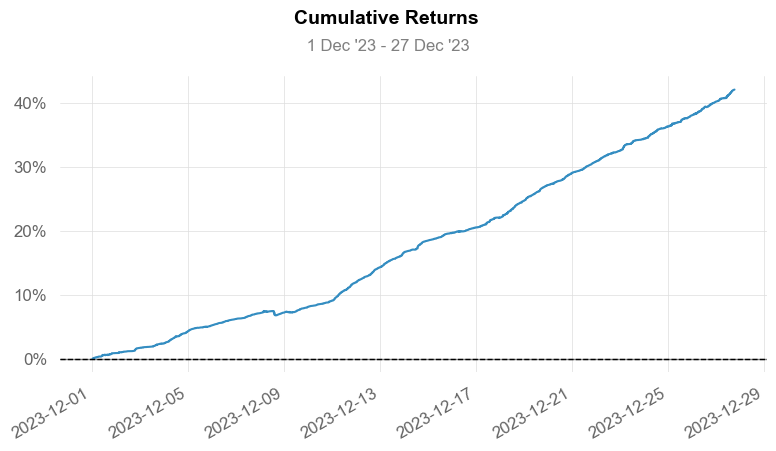

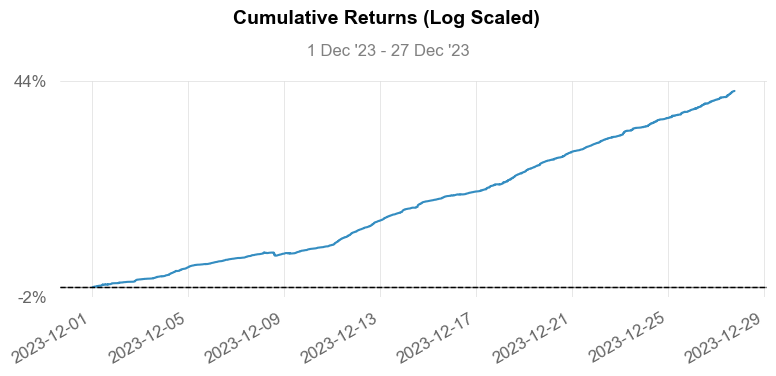

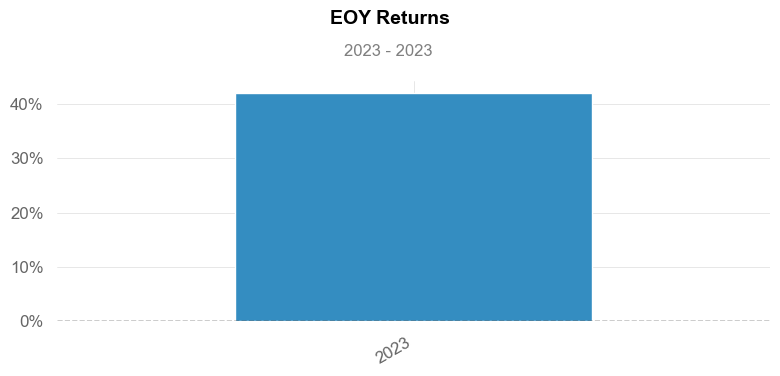

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


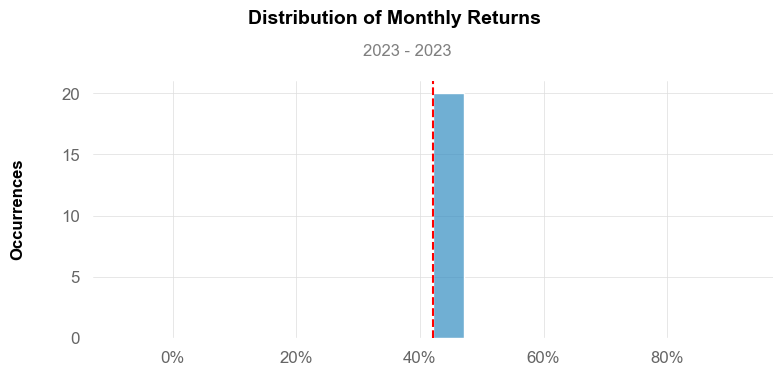

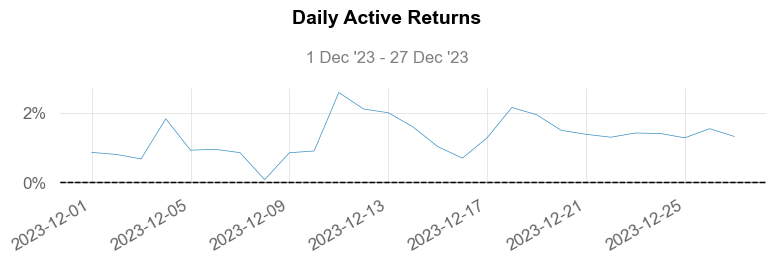

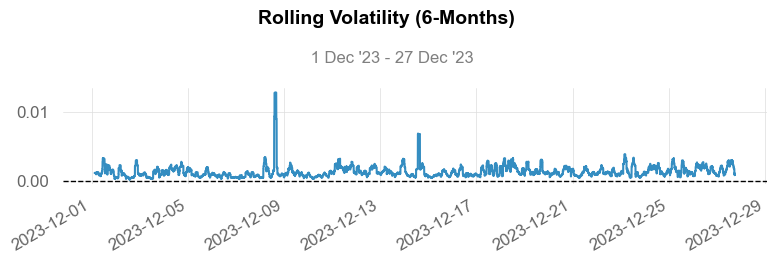

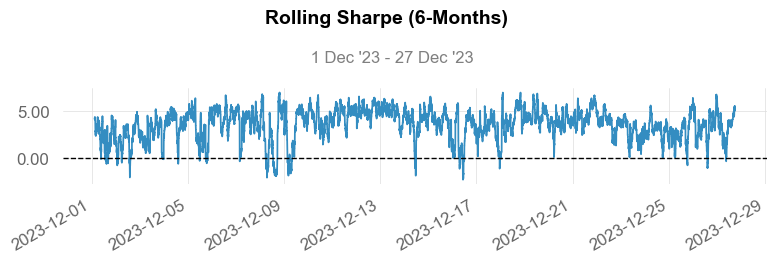

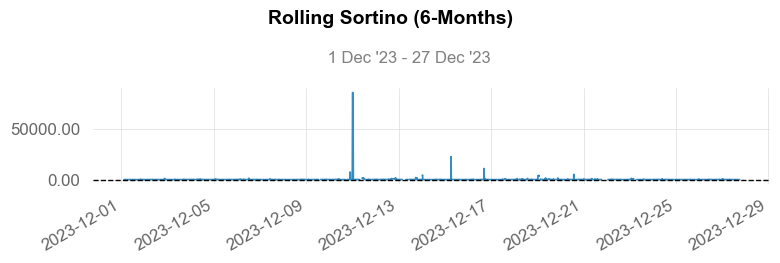

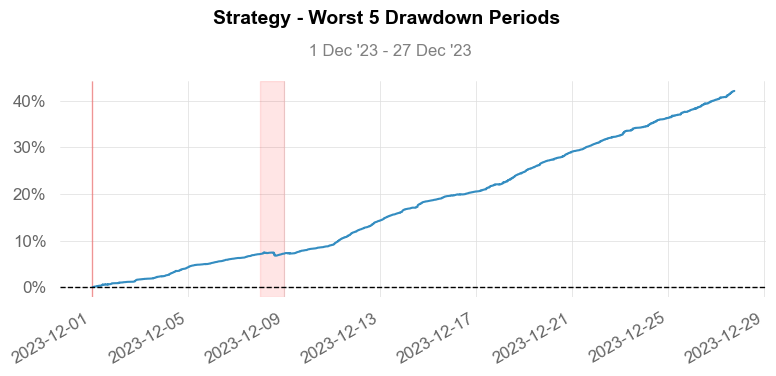

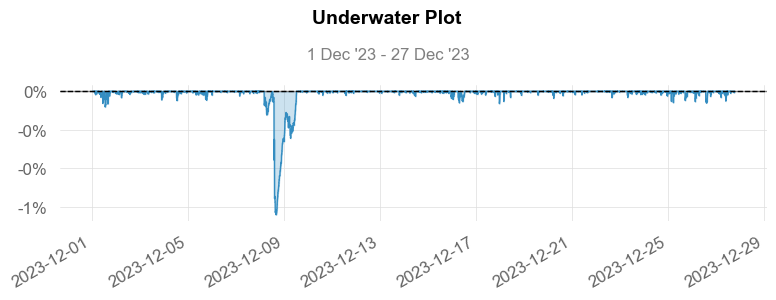

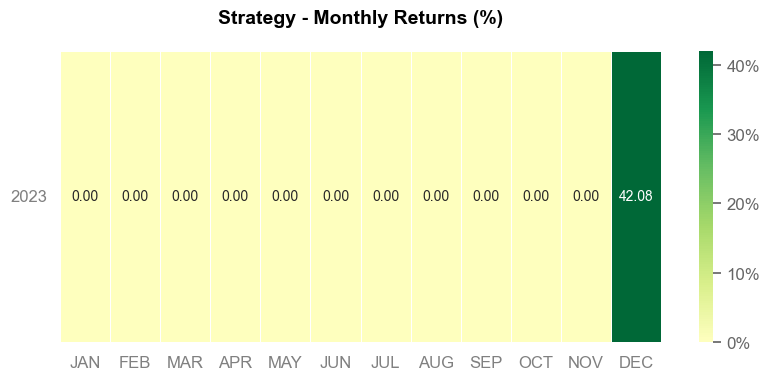

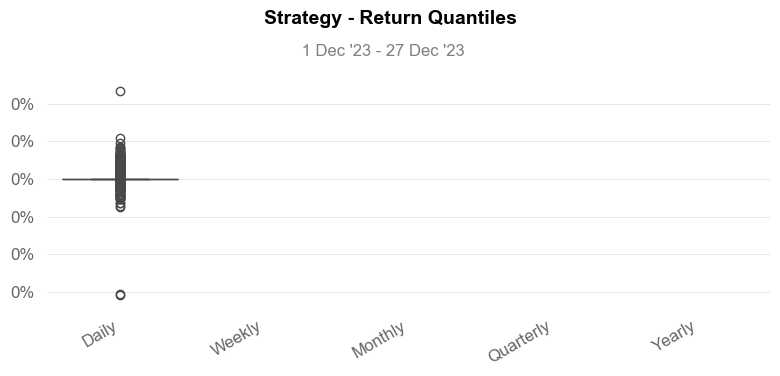

In [21]:
qs.reports.full(best_return['returns'])